In [8]:
# General imports
import pandas as pd

# Grid search
from library.genetic_algorithms.grid_search_parallelized import grid_search_par
from library.genetic_algorithms.mutation import swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation
from library.genetic_algorithms.crossover import cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover
from library.genetic_algorithms.selection import fitness_proportionate_selection, ranking_selection, tournament_selection

# Plotting
from matplotlib import pyplot as plt
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import plotly.graph_objects as go
from IPython.display import display

from functools import partial


In [9]:

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import plotly.graph_objects as go
from IPython.display import display


In [10]:
seating_data= pd.read_csv("seating_data.csv", index_col=0)

In [11]:
relationships_mtx=seating_data.to_numpy()

In [12]:
relationships_mtx

array([[   0, 5000,    0, ...,    0,    0,    0],
       [5000,    0,  700, ...,    0,    0,    0],
       [   0,  700,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,  700,  700],
       [   0,    0,    0, ...,  700,    0,  900],
       [   0,    0,    0, ...,  700,  900,    0]], dtype=int64)

# Experiment with different mutation, crossover and selection methods

## Fixed hyperparameters:
- population size = 100
- max generations = 100
- crossover probability = 0.9
- mutation probability = 0.1
- when selection method is tournment: tournment size = 3

In [13]:
# Testing grid search code 

results = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation],
    crossover_functions=[cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover],
    selection_functions=[fitness_proportionate_selection, ranking_selection, tournament_selection],
    elitism=[0,1]
)

results #results is empty, therefore nothing is printed

[{'mutation': 'heuristic_mutation',
  'crossover': 'geometric_crossover',
  'selection': 'tournament_selection',
  'elitism': 1,
  'last_gen_avg_fitness': 78346.66666666667,
  'solution_highest_fitness': <library.SA_problem.seating_arrangement.SASolution at 0x1a934b57ad0>,
  'execution_time': 23.903681993484497}]

In [14]:
results_table1 = pd.DataFrame(results).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table1

# Experimental Analysis

In [15]:
#avg_fitness_per_gen= pd.read_csv("avg_fitness_per_generation.csv")
fitness_per_run= pd.read_csv("fitness_per_run.csv")


In [16]:
median_fit_per_gen = fitness_per_run.groupby(
    ["mutation", "crossover", "selection", "elitism", "generation"]
)["fitness"].median().reset_index(name="median_fitness")

median_fit_per_gen.to_csv("median_fit_per_generation.csv", index=False)

In [17]:
median_fit_per_gen= pd.read_csv("median_fit_per_generation.csv")

In [18]:
#print(avg_fitness_per_gen.shape)
print(fitness_per_run.shape)
print(median_fit_per_gen.shape)

(288000, 7)
(9600, 6)


In [19]:
fitness_per_run.head()

run       mutation        crossover                        selection  \
0    1  swap_mutation  cycle_crossover  fitness_proportionate_selection   
1    1  swap_mutation  cycle_crossover  fitness_proportionate_selection   
2    1  swap_mutation  cycle_crossover  fitness_proportionate_selection   
3    1  swap_mutation  cycle_crossover  fitness_proportionate_selection   
4    1  swap_mutation  cycle_crossover  fitness_proportionate_selection   

   elitism  generation  fitness  
0        0           1    22400  
1        0           2    22900  
2        0           3    22400  
3        0           4    22800  
4        0           5    24900

In [20]:
median_fit_per_gen.head()

mutation        crossover                        selection  \
0  heuristic_mutation  cycle_crossover  fitness_proportionate_selection   
1  heuristic_mutation  cycle_crossover  fitness_proportionate_selection   
2  heuristic_mutation  cycle_crossover  fitness_proportionate_selection   
3  heuristic_mutation  cycle_crossover  fitness_proportionate_selection   
4  heuristic_mutation  cycle_crossover  fitness_proportionate_selection   

   elitism  generation  median_fitness  
0        0           1         24500.0  
1        0           2         24800.0  
2        0           3         25600.0  
3        0           4         26750.0  
4        0           5         27000.0

## Tracking Performance Across Generations for Different Operators With Median

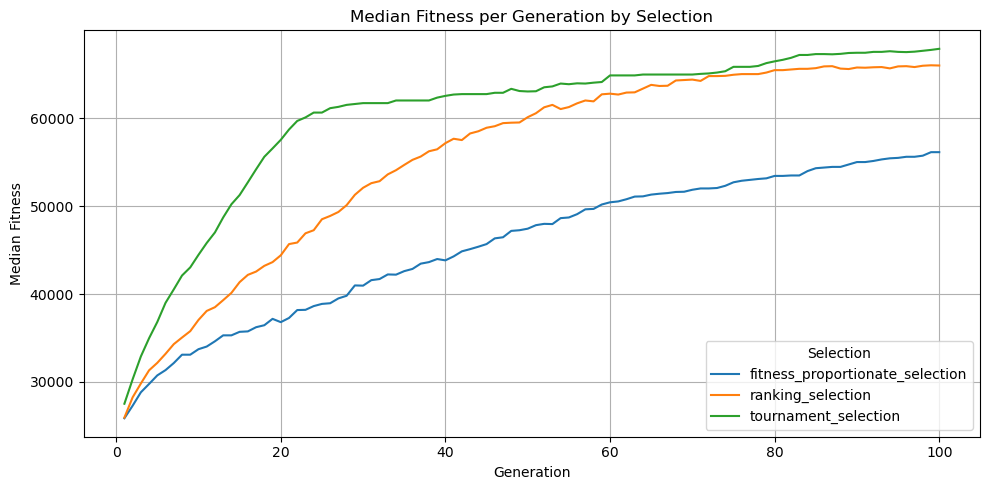

Median Fitness by selection method:


selection
tournament_selection               61450.0
ranking_selection                  59425.0
fitness_proportionate_selection    46600.0
Name: median_fitness, dtype: float64

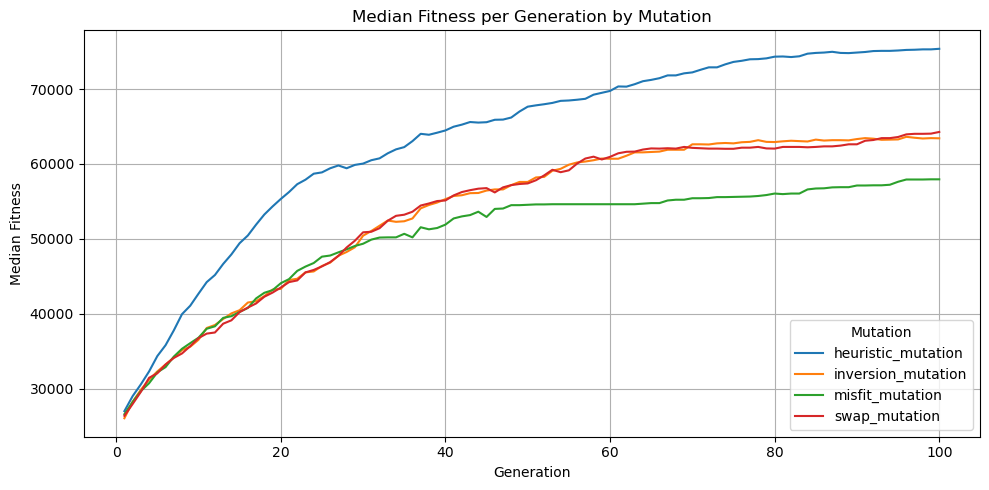

Median Fitness by mutation method:


mutation
heuristic_mutation    65350.0
swap_mutation         56300.0
inversion_mutation    55800.0
misfit_mutation       50400.0
Name: median_fitness, dtype: float64

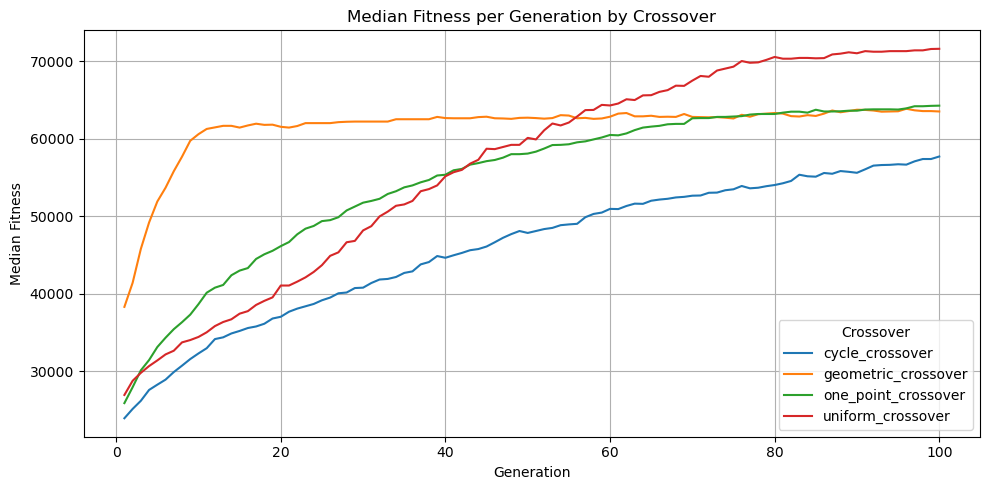

Median Fitness by crossover method:


crossover
geometric_crossover    62100.0
uniform_crossover      55025.0
one_point_crossover    53475.0
cycle_crossover        43700.0
Name: median_fitness, dtype: float64

In [21]:
def plot_median_fitness_by_operator(df, operator_name):
    grouped = df.groupby([operator_name, "generation"])["median_fitness"].median().reset_index()

    plt.figure(figsize=(10, 5))
    for op in grouped[operator_name].unique():
        subset = grouped[grouped[operator_name] == op]
        plt.plot(subset["generation"], subset["median_fitness"], label=op)

    plt.title(f"Median Fitness per Generation by {operator_name.capitalize()}")
    plt.xlabel("Generation")
    plt.ylabel("Median Fitness")
    plt.legend(title=operator_name.capitalize(), loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot para cada operador
for operator in ["selection", "mutation", "crossover"]:
    plot_median_fitness_by_operator(median_fit_per_gen, operator)
    median_by_operator = median_fit_per_gen.groupby(operator)["median_fitness"].median().sort_values(ascending=False)
    print(f"Median Fitness by {operator} method:")
    display(median_by_operator.round(2))



In [22]:
median_by_elitism = median_fit_per_gen.groupby("elitism")["median_fitness"].median().sort_values(ascending=False)
print("Median Fitness by Elitism:")
display(median_by_elitism.round(2))

Median Fitness by Elitism:


elitism
1    58250.0
0    56050.0
Name: median_fitness, dtype: float64

## Tracking Performance Across Generations for Different Operators With Mean

In [23]:
def plot_avg_fitness_by_operator(df, operator_name):
    grouped = df.groupby([operator_name, "generation"])["avg_fitness"].mean().reset_index()

    plt.figure(figsize=(10, 5))
    for op in grouped[operator_name].unique():
        subset = grouped[grouped[operator_name] == op]
        plt.plot(subset["generation"], subset["avg_fitness"], label=op)

    plt.title(f"Average Fitness per Generation by {operator_name.capitalize()}")
    plt.xlabel("Generation")
    plt.ylabel("Average Fitness")
    plt.legend(title=operator_name.capitalize(), loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot para cada operador
for operator in ["selection", "mutation", "crossover"]:
    plot_avg_fitness_by_operator(avg_fitness_per_gen, operator)

NameError: name 'avg_fitness_per_gen' is not defined

## Plot median fitness per gen

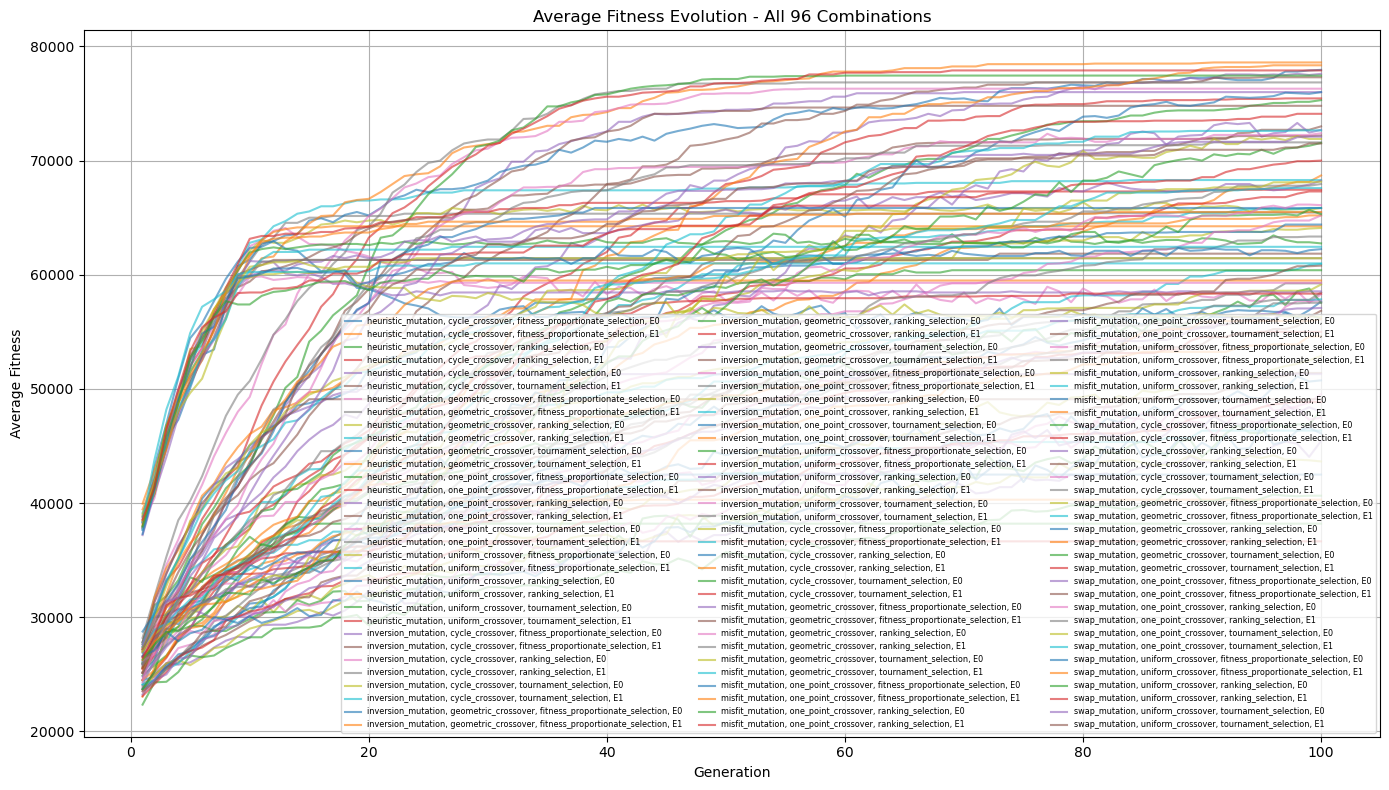

In [ ]:
median_fit_per_gen["combination"] = median_fit_per_gen.apply(
    lambda row: f"{row['mutation']}, {row['crossover']}, {row['selection']}, E{row['elitism']}",
    axis=1
)

# Plot all 48 curves
plt.figure(figsize=(14, 8))

for combo in median_fit_per_gen["combination"].unique():
    subset = median_fit_per_gen[median_fit_per_gen["combination"] == combo]
    plt.plot(subset["generation"], subset["median_fitness"], label=combo, alpha=0.6)

plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Average Fitness Evolution - All 96 Combinations")
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize="xx-small", ncol=3, loc="lower right")
plt.show()

Due to the high number of combinations being evaluated, we will focus on plotting only the top 5 combinations. These top 5 are selected based on achieving the highest median fitness values in the final generation. By doing so, we can clearly visualize and compare the best-performing configurations in terms of fitness evolution over the generations.

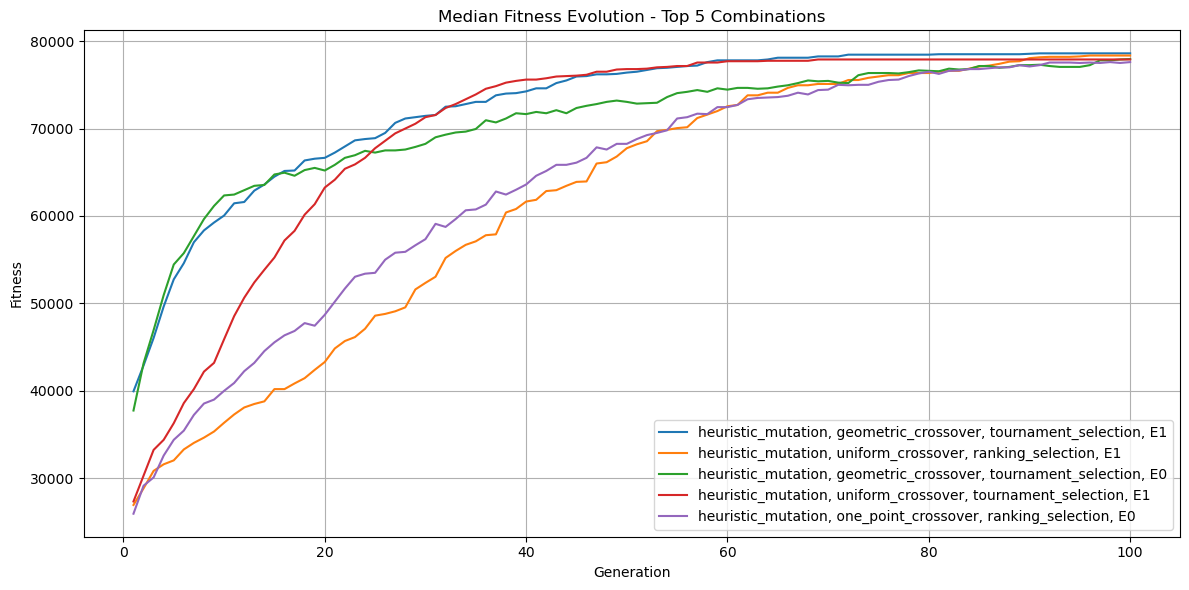

In [ ]:
# Filter the last generation
last_gen = median_fit_per_gen[median_fit_per_gen["generation"] == median_fit_per_gen["generation"].max()]

# Select top 5 combinations by average fitness in the last generation
top5_combinations = last_gen.sort_values(by="median_fitness", ascending=False)["combination"].head(5).unique()

# Filter data for these top 5 combinations
df_top5 = median_fit_per_gen[median_fit_per_gen["combination"].isin(top5_combinations)]

# Plot the curves
plt.figure(figsize=(12, 6))
for combo in top5_combinations:
    subset = df_top5[df_top5["combination"] == combo]
    plt.plot(subset["generation"], subset["median_fitness"], label=combo)

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Median Fitness Evolution - Top 5 Combinations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We are going to add the interquartile range (IQR) shading to our plot

In [ ]:
stats = fitness_per_run.groupby(
    ["mutation", "crossover", "selection", "elitism", "generation"]
)["fitness"].agg(
    median_fitness="median",
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75)
).reset_index()

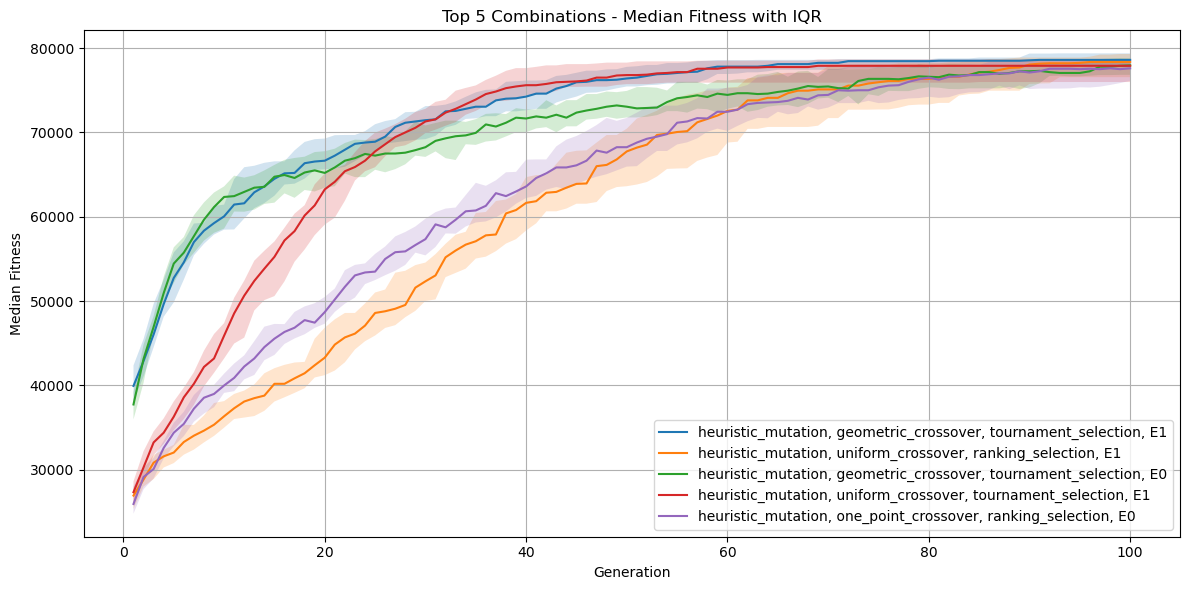

In [ ]:
stats["combination"] = stats.apply(
    lambda row: f"{row['mutation']}, {row['crossover']}, {row['selection']}, E{row['elitism']}",
    axis=1
)

last_gen = stats[stats["generation"] == stats["generation"].max()]
top5_combinations = last_gen.sort_values(by="median_fitness", ascending=False)["combination"].head(5).unique()

df_top5 = stats[stats["combination"].isin(top5_combinations)]


plt.figure(figsize=(12, 6))
for combo in top5_combinations:
    subset = df_top5[df_top5["combination"] == combo]
    plt.plot(subset["generation"], subset["median_fitness"], label=combo)
    plt.fill_between(
    subset["generation"],
    subset["q1"],
    subset["q3"],
    alpha=0.2
    )

plt.xlabel("Generation")
plt.ylabel("Median Fitness")
plt.title("Top 5 Combinations - Median Fitness with IQR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot average fitness per gen 

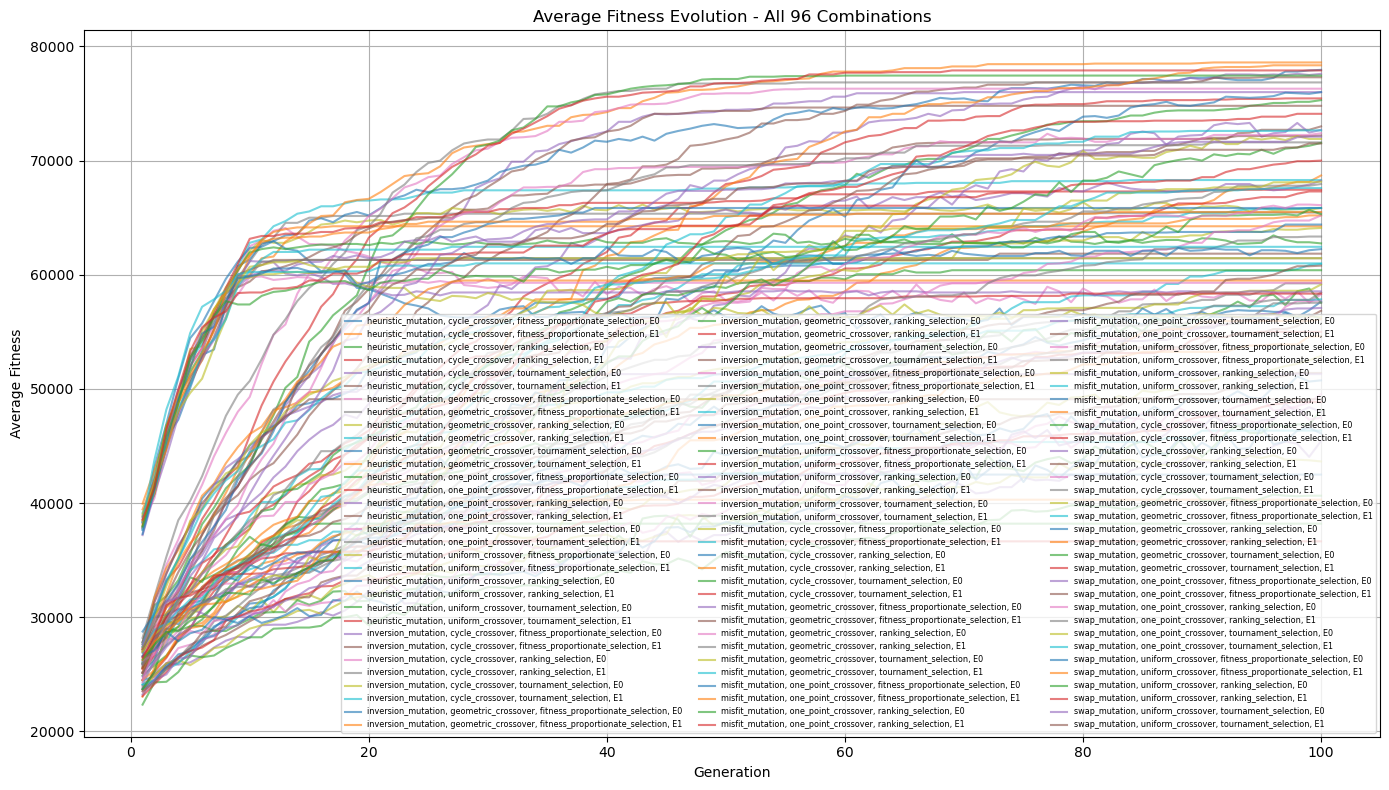

In [ ]:
avg_fitness_per_gen["combination"] = avg_fitness_per_gen.apply(
    lambda row: f"{row["mutation"]}, {row["crossover"]}, {row["selection"]}, E{row["elitism"]}",
    axis=1
)

# Plot all 48 curves
plt.figure(figsize=(14, 8))

for combo in avg_fitness_per_gen["combination"].unique():
    subset = avg_fitness_per_gen[avg_fitness_per_gen["combination"] == combo]
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo, alpha=0.6)

plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Average Fitness Evolution - All 96 Combinations")
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize="xx-small", ncol=3, loc="lower right")
plt.show()

Due to the high number of combinations being evaluated, we will focus on plotting only the top 5 combinations. These top 5 are selected based on achieving the highest average fitness values in the final generation. By doing so, we can clearly visualize and compare the best-performing configurations in terms of fitness evolution over the generations.

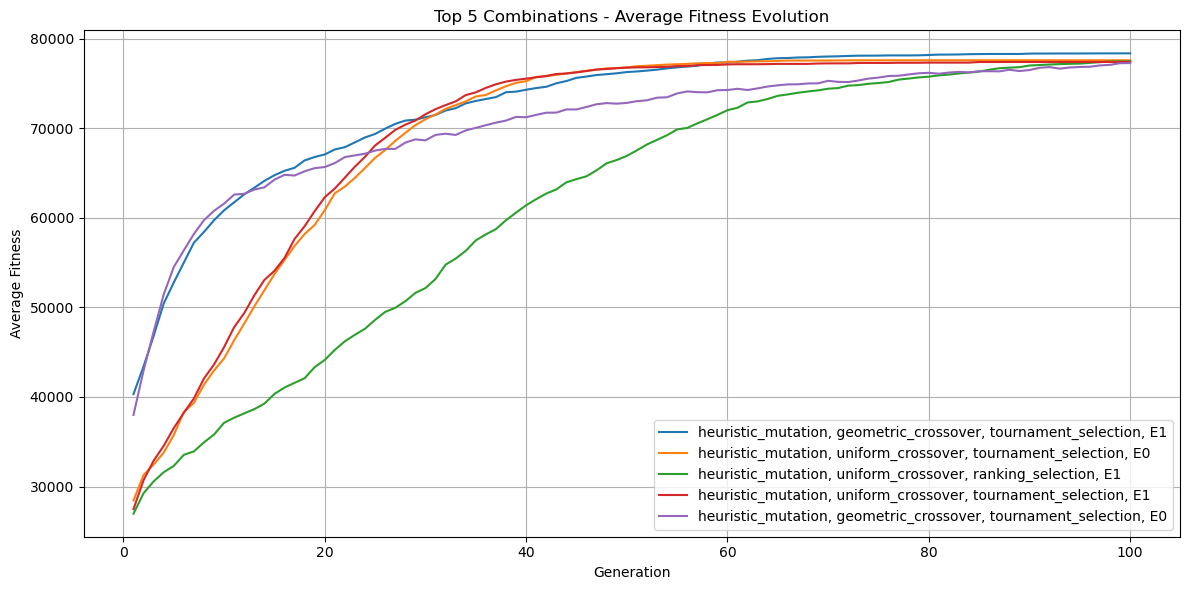

In [ ]:
# Filter the last generation
last_gen = avg_fitness_per_gen[avg_fitness_per_gen["generation"] == avg_fitness_per_gen["generation"].max()]

# Select top 5 combinations by average fitness in the last generation
top5_combinations = last_gen.sort_values(by="avg_fitness", ascending=False)["combination"].head(5).unique()

# Filter data for these top 5 combinations
df_top5 = avg_fitness_per_gen[avg_fitness_per_gen["combination"].isin(top5_combinations)]

# Plot the curves
plt.figure(figsize=(12, 6))
for combo in top5_combinations:
    subset = df_top5[df_top5["combination"] == combo]
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo)

plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Top 5 Combinations - Average Fitness Evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We are going to add the standard desviation to our plot

In [ ]:
stats = fitness_per_run.groupby(
    ["mutation", "crossover", "selection", "elitism", "generation"]
)["fitness"].agg(["mean", "std"]).reset_index()


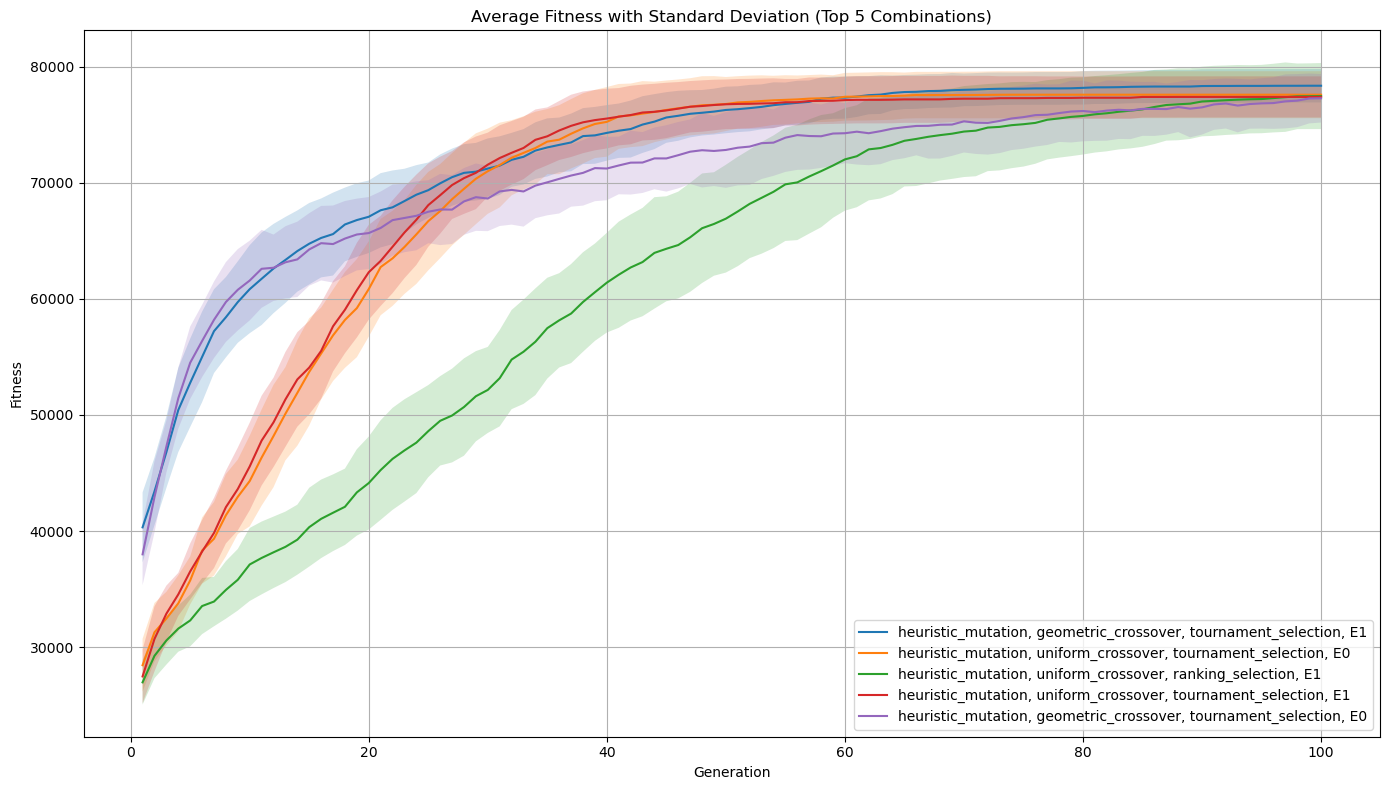

In [ ]:
stats["combination"] = stats.apply(
    lambda row: f"{row["mutation"]}, {row["crossover"]}, {row["selection"]}, E{row["elitism"]}",
    axis=1
)

stats.rename(columns={"mean": "avg_fitness", "std": "std_fitness"}, inplace=True)

stats_top5 = stats[stats["combination"].isin(top5_combinations)]


plt.figure(figsize=(14, 8))

for combo in top5_combinations:
    subset = stats_top5[stats_top5["combination"] == combo]
    
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo)
    
    # Sombrear o intervalo avg ± std
    plt.fill_between(
        subset["generation"],
        subset["avg_fitness"] - subset["std_fitness"],
        subset["avg_fitness"] + subset["std_fitness"],
        alpha=0.2
    )

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Average Fitness with Standard Deviation (Top 5 Combinations)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Performs Statistical Tests -Median

In [ ]:
grouped = median_fit_per_gen.groupby("combination")["median_fitness"].apply(list)
score_df = pd.DataFrame(grouped.tolist(), index=grouped.index).T
score_df = score_df.dropna(axis=1)

# Global significance test 
stat, p = friedmanchisquare(*[score_df[col] for col in score_df.columns])
print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")

alpha_sig = 0.05
if p < alpha_sig:
    print("There are statistically significant differences between the configurations.")

    # Pair-wise test
    nemenyi = sp.posthoc_nemenyi_friedman(score_df.to_numpy())
    display(
        nemenyi.style
            .set_caption("Post-hoc Nemenyi test")
            .format(precision=4)
            .map(lambda v: 'background-color: lightcoral' if v < alpha_sig else '')
            .set_properties(**{'text-align': 'center'})
    )
else:
    print("No statistically significant differences were found between the configurations.")

Friedman test statistic: 7973.5998, p-value: 0.0000
There are statistically significant differences between the configurations.


In [ ]:
# abreviations for the operators (for better visualization)
abbr = {
    'heuristic_mutation': 'HM',
    'swap_mutation': 'SM',
    'inversion_mutation': 'IM',
    'misfit_mutation': 'MM',
    'geometric_crossover': 'GC',
    'uniform_crossover': 'UC',
    'one_point_crossover': 'OPC',
    'cycle_crossover': 'CC',
    'tournament_selection': 'TS',
    'ranking_selection': 'RS',
    'fitness_proportionate_selection': 'FPS',
}

def abbreviate_config(config):
    parts = [part.strip() for part in config.split(',')]
    return '-'.join(abbr.get(part, part) for part in parts)

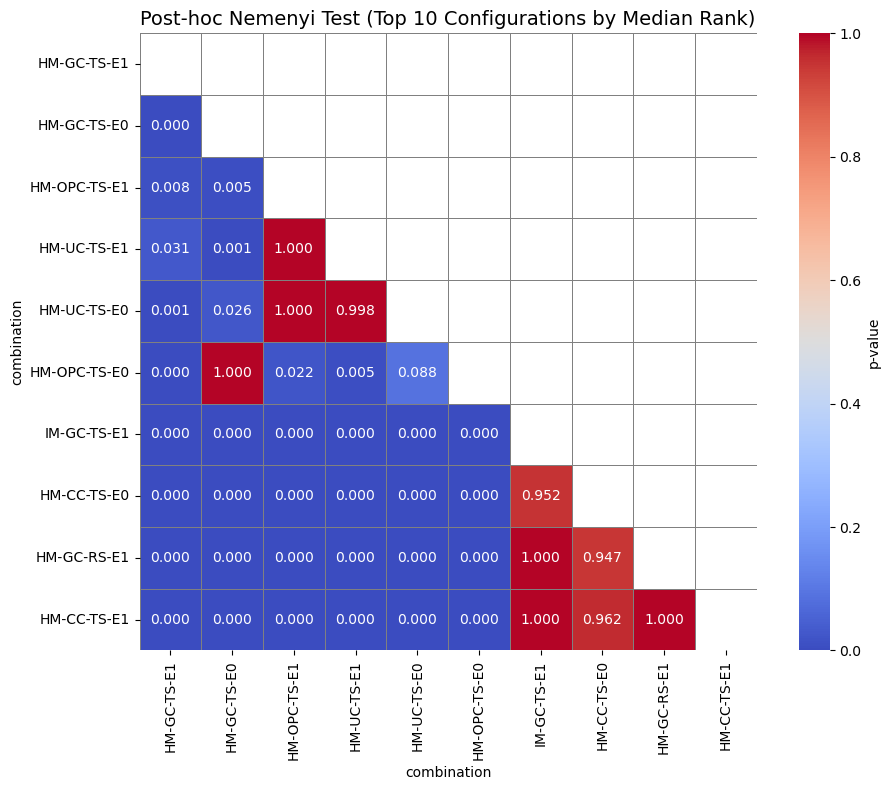

In [ ]:
# post-hoc Nemenyi test for the 10 configurations with the best average fitness
mean_ranks = score_df.rank(axis=1, method='average', ascending=False).mean().sort_values()

top_n = 10
top_configs = mean_ranks.head(top_n).index

top_score_df = score_df[top_configs]
nemenyi_top = sp.posthoc_nemenyi_friedman(top_score_df.to_numpy())
nemenyi_top.index = nemenyi_top.columns = top_score_df.columns

# Abreviate the configuration names for better visualization
abbr_labels = [abbreviate_config(config) for config in top_score_df.columns]

plt.figure(figsize=(10, 8))
sns.heatmap(
    nemenyi_top,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar_kws={"label": "p-value"},
    linewidths=0.5,
    linecolor='gray',
    mask=np.triu(np.ones_like(nemenyi_top, dtype=bool)),
    square=True
)

plt.title(f"Post-hoc Nemenyi Test (Top {len(abbr_labels)} Configurations by Median Rank)", fontsize=14)
plt.xticks(ticks=np.arange(len(abbr_labels)) + 0.5, labels=abbr_labels, rotation=90)
plt.yticks(ticks=np.arange(len(abbr_labels)) + 0.5, labels=abbr_labels, rotation=0)

plt.tight_layout()
plt.show()



In [ ]:
df_long = score_df.melt(var_name="Configuration", value_name="Fitness")

df_long['Selection'] = df_long['Configuration'].apply(lambda x: x.split(',')[2])

df_long['Config_Abbr'] = df_long['Configuration'].apply(abbreviate_config)

stats_df = df_long.groupby("Configuration")["Fitness"].agg(
    min_score="min",
    q1_score=lambda x: np.percentile(x, 25),
    median_score="median",
    q3_score=lambda x: np.percentile(x, 75),
    max_score="max"
).reset_index()

def make_hover(config):
    stats = stats_df[stats_df['Configuration'] == config].iloc[0]
    return (
        f"Max: {stats.max_score:.2f}<br>"
        f"Q3: {stats.q3_score:.2f}<br>"
        f"Median: {stats.median_score:.2f}<br>"
        f"Q1: {stats.q1_score:.2f}<br>"
        f"Min: {stats.min_score:.2f}"
    )

df_long['hover'] = df_long['Configuration'].map(make_hover)

selection_types = df_long['Selection'].unique()

for sel_type in selection_types:
    df_sel = df_long[df_long['Selection'] == sel_type]

    fig = go.Figure()
    fig.add_trace(go.Box(
        x=df_sel['Config_Abbr'],
        y=df_sel['Fitness'],
        text=df_sel['hover'],
        hoverinfo='text',
        fillcolor='rgba(108, 140, 200, 0.3)',
        line=dict(color='rgba(108, 140, 200, 1)'),
        boxpoints='all',
        jitter=0,
        pointpos=0,
        marker=dict(color='rgba(108, 140, 200, 1)')
    ))

    fig.update_yaxes(title="Average Fitness", range=[0, df_long["Fitness"].max() * 1.05])
    fig.update_layout(
        title=f"Fitness per Configuration ({sel_type})",
        xaxis_title="Configuration",
        width=1000,
        height=600,
        plot_bgcolor='#f1f1f1',
        xaxis_tickfont=dict(size=10),
        xaxis_tickangle=-90,
        margin=dict(l=50, r=50, t=50, b=150),
        showlegend=False
    )
    fig.show()


In [ ]:
print("Fitness Summary per Configuration:")
display(stats_df.sort_values("median_score", ascending=False).round(2))

Fitness Summary per Configuration:


Configuration  min_score  q1_score  \
22  heuristic_mutation-uniform_crossover-tournamen...   28450.00  67334.17   
23  heuristic_mutation-uniform_crossover-tournamen...   27483.33  68706.67   
11  heuristic_mutation-geometric_crossover-tournam...   40320.00  69795.83   
17  heuristic_mutation-one_point_crossover-tournam...   28413.33  70142.50   
16  heuristic_mutation-one_point_crossover-tournam...   27420.00  69125.83   
..                                                ...        ...       ...   
52  misfit_mutation-cycle_crossover-tournament_sel...   24133.33  38333.33   
90  swap_mutation-uniform_crossover-fitness_propor...   26556.67  32756.67   
24  inversion_mutation-cycle_crossover-fitness_pro...   24163.33  32662.50   
53  misfit_mutation-cycle_crossover-tournament_sel...   25310.00  36800.00   
72  swap_mutation-cycle_crossover-fitness_proporti...   22696.67  31830.00   

    median_score  q3_score  max_score  
22      76841.67  77573.33   77573.33  
23      76765.00  77276.67   77383.33  
11      76293.33  78101.67   78346.67  
17      76186.67  76283.33   76283.33  
16      75445.00  75956.67   75956.67  
..           ...       ...        ...  
52      38333.33  38333.33   38333.33  
90      38271.67  43168.33   46836.67  
24      37263.33  41927.50   44693.33  
53      36843.33  36843.33   36843.33  
72      35951.67  39205.83   41470.00  

[96 rows x 6 columns]

In [ ]:
top_configs = stats_df.sort_values("median_score", ascending=False).head(10)
top_10_names = top_configs['Configuration'].tolist()

df_top = df_long[df_long['Configuration'].isin(top_10_names)].copy()

df_top['Config_Abbr'] = df_top['Configuration'].apply(abbreviate_config)

fig = go.Figure()
fig.add_trace(go.Box(
    x=df_top['Config_Abbr'],
    y=df_top['Fitness'],
    text=df_top['hover'],
    hoverinfo='text',
    boxpoints='all',
    jitter=0,
    pointpos=0,
    marker=dict(color='rgba(108, 140, 200, 1)')
))

fig.update_layout(
    title="Top 10 Configurations by Fitness",
    xaxis_title="Configuration",
    yaxis_title="Fitness",
    width=1000,
    height=600,
    xaxis_tickangle=-45
)
fig.show()


# Performs statistical tests-antes

In [ ]:
avg_fitness_per_gen['configuration'] = avg_fitness_per_gen[['mutation', 'crossover', 'selection', 'elitism']].astype(str).agg('-'.join, axis=1)

# Group avg_fitness values ​​by configuration
grouped = avg_fitness_per_gen.groupby('configuration')['avg_fitness'].apply(list)

score_df = pd.DataFrame(grouped.tolist(), index=grouped.index).T
score_df = score_df.dropna(axis=1)

# Global significance test 
stat, p = friedmanchisquare(*[score_df[col] for col in score_df.columns])
print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")

alpha_sig = 0.05
if p < alpha_sig:
    print("There are statistically significant differences between the configurations.")

    # Pair-wise test
    nemenyi = sp.posthoc_nemenyi_friedman(score_df.to_numpy())
    display(
        nemenyi.style
            .set_caption("Post-hoc Nemenyi test")
            .format(precision=4)
            .map(lambda v: 'background-color: lightcoral' if v < alpha_sig else '')
            .set_properties(**{'text-align': 'center'})
    )
else:
    print("No statistically significant differences were found between the configurations.")

Friedman test statistic: 7971.9967, p-value: 0.0000
There are statistically significant differences between the configurations.


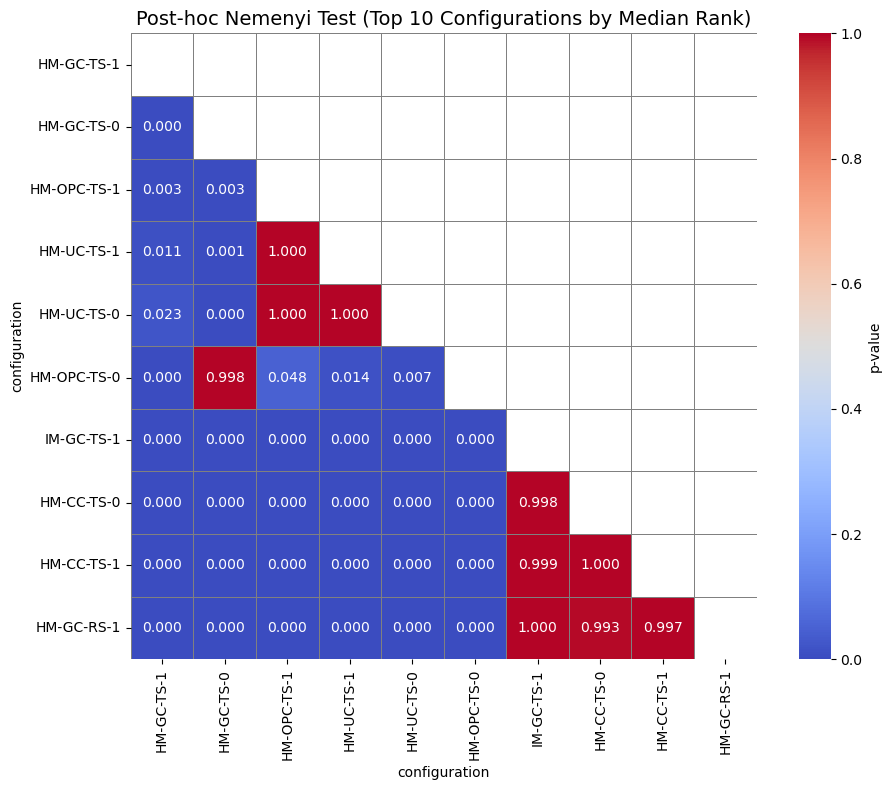

In [ ]:
# post-hoc Nemenyi test for the 10 configurations with the best average fitness
mean_ranks = score_df.rank(axis=1, method='average', ascending=False).mean().sort_values()

top_n = 10
top_configs = mean_ranks.head(top_n).index

top_score_df = score_df[top_configs]
nemenyi_top = sp.posthoc_nemenyi_friedman(top_score_df.to_numpy())
nemenyi_top.index = nemenyi_top.columns = top_score_df.columns

plt.figure(figsize=(10, 8))
sns.heatmap(
    nemenyi_top,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar_kws={"label": "p-value"},
    linewidths=0.5,
    linecolor='gray',
    mask=np.triu(np.ones_like(nemenyi_top, dtype=bool)),
    square=True
)
plt.title(f"Post-hoc Nemenyi Test (Top {top_n} Configurations by Mean Rank)", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# abreviations for the operators (for better visualization)
abbr = {
    'heuristic_mutation': 'HM',
    'swap_mutation': 'SM',
    'inversion_mutation': 'IM',
    'misfit_mutation': 'MM',
    'geometric_crossover': 'GC',
    'uniform_crossover': 'UC',
    'one_point_crossover': 'OPC',
    'cycle_crossover': 'CC',
    'tournament_selection': 'TS',
    'ranking_selection': 'RS',
    'fitness_proportionate_selection': 'FPS',
}

def abbreviate_config(config):
    parts = config.split('-')
    return '-'.join(abbr.get(part, part) for part in parts)

In [ ]:
df_long = score_df.melt(var_name="Configuration", value_name="Fitness")

df_long['Selection'] = df_long['Configuration'].apply(lambda x: x.split('-')[2])

df_long['Config_Abbr'] = df_long['Configuration'].apply(abbreviate_config)

stats_df = df_long.groupby("Configuration")["Fitness"].agg(
    min_score="min",
    q1_score=lambda x: np.percentile(x, 25),
    median_score="median",
    q3_score=lambda x: np.percentile(x, 75),
    max_score="max"
).reset_index()

def make_hover(config):
    stats = stats_df[stats_df['Configuration'] == config].iloc[0]
    return (
        f"Max: {stats.max_score:.2f}<br>"
        f"Q3: {stats.q3_score:.2f}<br>"
        f"Median: {stats.median_score:.2f}<br>"
        f"Q1: {stats.q1_score:.2f}<br>"
        f"Min: {stats.min_score:.2f}"
    )

df_long['hover'] = df_long['Configuration'].map(make_hover)

selection_types = df_long['Selection'].unique()

for sel_type in selection_types:
    df_sel = df_long[df_long['Selection'] == sel_type]

    fig = go.Figure()
    fig.add_trace(go.Box(
        x=df_sel['Config_Abbr'],
        y=df_sel['Fitness'],
        text=df_sel['hover'],
        hoverinfo='text',
        fillcolor='rgba(108, 140, 200, 0.3)',
        line=dict(color='rgba(108, 140, 200, 1)'),
        boxpoints='all',
        jitter=0,
        pointpos=0,
        marker=dict(color='rgba(108, 140, 200, 1)')
    ))

    fig.update_yaxes(title="Average Fitness", range=[0, df_long["Fitness"].max() * 1.05])
    fig.update_layout(
        title=f"Fitness per Configuration ({sel_type})",
        xaxis_title="Configuration",
        width=1000,
        height=600,
        plot_bgcolor='#f1f1f1',
        xaxis_tickfont=dict(size=10),
        xaxis_tickangle=-90,
        margin=dict(l=50, r=50, t=50, b=150),
        showlegend=False
    )
    fig.show()


In [ ]:
print("Fitness Summary per Configuration:")
display(stats_df.sort_values("median_score", ascending=False).round(2))

Fitness Summary per Configuration:


Configuration  min_score  q1_score  \
22  heuristic_mutation-uniform_crossover-tournamen...   28450.00  67334.17   
23  heuristic_mutation-uniform_crossover-tournamen...   27483.33  68706.67   
11  heuristic_mutation-geometric_crossover-tournam...   40320.00  69795.83   
17  heuristic_mutation-one_point_crossover-tournam...   28413.33  70142.50   
16  heuristic_mutation-one_point_crossover-tournam...   27420.00  69125.83   
..                                                ...        ...       ...   
52  misfit_mutation-cycle_crossover-tournament_sel...   24133.33  38333.33   
90  swap_mutation-uniform_crossover-fitness_propor...   26556.67  32756.67   
24  inversion_mutation-cycle_crossover-fitness_pro...   24163.33  32662.50   
53  misfit_mutation-cycle_crossover-tournament_sel...   25310.00  36800.00   
72  swap_mutation-cycle_crossover-fitness_proporti...   22696.67  31830.00   

    median_score  q3_score  max_score  
22      76841.67  77573.33   77573.33  
23      76765.00  77276.67   77383.33  
11      76293.33  78101.67   78346.67  
17      76186.67  76283.33   76283.33  
16      75445.00  75956.67   75956.67  
..           ...       ...        ...  
52      38333.33  38333.33   38333.33  
90      38271.67  43168.33   46836.67  
24      37263.33  41927.50   44693.33  
53      36843.33  36843.33   36843.33  
72      35951.67  39205.83   41470.00  

[96 rows x 6 columns]

# Choosing the best combination

In [ ]:
top5_configs = stats_df.sort_values("median_score", ascending=False).head(5)
top5_names = top5_configs['Configuration'].tolist()

df_top = df_long[df_long['Configuration'].isin(top5_names)].copy()

df_top['Config_Abbr'] = df_top['Configuration'].apply(abbreviate_config)

fig = go.Figure()
fig.add_trace(go.Box(
    x=df_top['Config_Abbr'],
    y=df_top['Fitness'],
    text=df_top['hover'],
    hoverinfo='text',
    boxpoints='all',
    jitter=0,
    pointpos=0,
    marker=dict(color='rgba(108, 140, 200, 1)')
))

fig.update_layout(
    title="Top 5 Configurations by Fitness",
    xaxis_title="Configuration",
    yaxis_title="Fitness",
    width=1000,
    height=600,
    xaxis_tickangle=-45
)
fig.show()


In [ ]:
print("Top 5 Configurations by Median Fitness:")
display(top5_configs.round(2))


Top 5 Configurations by Median Fitness:


Configuration  min_score  q1_score  \
22  heuristic_mutation, uniform_crossover, tournam...    27800.0   67687.5   
23  heuristic_mutation, uniform_crossover, tournam...    27350.0   68387.5   
17  heuristic_mutation, one_point_crossover, tourn...    28200.0   69950.0   
11  heuristic_mutation, geometric_crossover, tourn...    39950.0   69350.0   
16  heuristic_mutation, one_point_crossover, tourn...    27300.0   68662.5   

    median_score  q3_score  max_score  
22       77150.0   77450.0    77450.0  
23       76800.0   77900.0    77900.0  
17       76750.0   76850.0    76850.0  
11       76450.0   78450.0    78600.0  
16       75900.0   76300.0    76300.0

In [ ]:
# Filtra median_fit_per_gen para ficar só com as combinações top5
df_top5 = median_fit_per_gen[median_fit_per_gen["combination"].isin(top5_names)].copy()

# Depois agrupa, converte para DataFrame e faz o teste como antes
grouped = df_top5.groupby("combination")["median_fitness"].apply(list)
score_df = pd.DataFrame(grouped.tolist(), index=grouped.index).T
score_df = score_df.dropna(axis=1)

# Global significance test 
stat, p = friedmanchisquare(*[score_df[col] for col in score_df.columns])
print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")

alpha_sig = 0.05
if p < alpha_sig:
    print("There are statistically significant differences between the configurations.")

    # Pair-wise test
    nemenyi = sp.posthoc_nemenyi_friedman(score_df.to_numpy())
    display(
        nemenyi.style
            .set_caption("Post-hoc Nemenyi test")
            .format(precision=4)
            .map(lambda v: 'background-color: lightcoral' if v < alpha_sig else '')
            .set_properties(**{'text-align': 'center'})
    )
else:
    print("No statistically significant differences were found between the configurations.")


Friedman test statistic: 121.3380, p-value: 0.0000
There are statistically significant differences between the configurations.


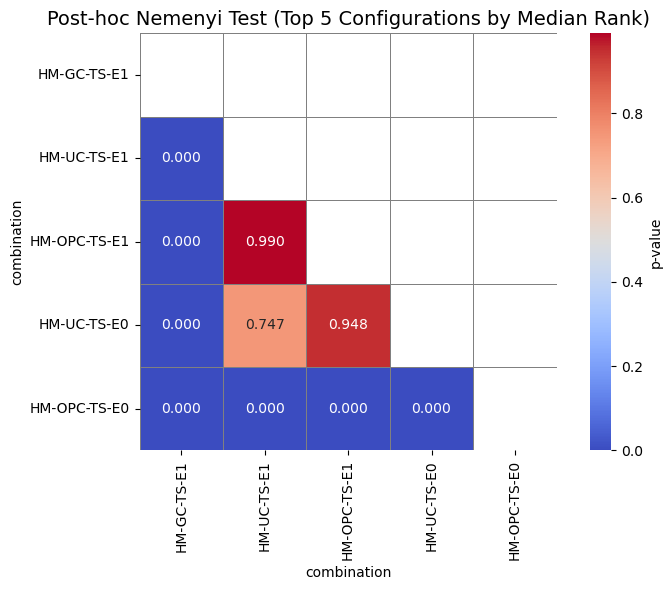

In [ ]:
# post-hoc Nemenyi test for the 10 configurations with the best average fitness
mean_ranks = score_df.rank(axis=1, method='average', ascending=False).mean().sort_values()

top_configs = mean_ranks.index

top_score_df = score_df[top_configs]
nemenyi_top = sp.posthoc_nemenyi_friedman(top_score_df.to_numpy())
nemenyi_top.index = nemenyi_top.columns = top_score_df.columns

# Abreviate the configuration names for better visualization
abbr_labels = [abbreviate_config(config) for config in top_score_df.columns]

plt.figure(figsize=(8, 6))
sns.heatmap(
    nemenyi_top,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar_kws={"label": "p-value"},
    linewidths=0.5,
    linecolor='gray',
    mask=np.triu(np.ones_like(nemenyi_top, dtype=bool)),
    square=True
)

plt.title(f"Post-hoc Nemenyi Test (Top {len(abbr_labels)} Configurations by Median Rank)", fontsize=14)
plt.xticks(ticks=np.arange(len(abbr_labels)) + 0.5, labels=abbr_labels, rotation=90)
plt.yticks(ticks=np.arange(len(abbr_labels)) + 0.5, labels=abbr_labels, rotation=0)

plt.tight_layout()
plt.show()

## Calculate success rate

As the global optimum is not known, we define a threshold value to evaluate the success rate of the algorithms. Solutions reaching or exceeding this threshold will be considered successful.

Tuning

In [ ]:
tourn3 = partial(tournament_selection, tournament_size=3)
tourn5 = partial(tournament_selection, tournament_size=5)
tourn2 = partial(tournament_selection, tournament_size=2)
tourn7 = partial(tournament_selection, tournament_size=7)

tourn3.name = "tournament_k3"
tourn5.name = "tournament_k5"
tourn2.name = "tournament_k2"
tourn7.name = "tournament_k7"

results2 = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[heuristic_mutation], # add best mutation
    crossover_functions=[geometric_crossover], # add best crossover
    selection_functions=[tourn3, tourn5, tourn2, tourn7], # add best selection
    elitism=[1,3,5]
)

In [ ]:
results_table2 = pd.DataFrame(results2).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table2